<a href="https://colab.research.google.com/github/yoav1131/Deep-Learning-Course/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training Convolutional Neural Networks

In this notebook we train a convolutional neural network for image classification. Our goal here is to compare comvolutional networks to fully-connected (dense) networks with similar number of parameters, demonstrating their ability to exploit inherent structures and properties of neural images.

Since we are going to use non-synthetic datasets, we use the *torchvision* package, which includes plenty of conventional datasets and methods for processing and manipolating data.

In [161]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Before we begin, we introduce a local function for computing the number of trainable parameters of a model. We will use it in the sequel to compare convolutional networks with fully connected ones.

In [162]:
# function to count number of parameters
def get_n_params(model):
  np = 0
  for p in list(model.parameters()):
    np += p.nelement()
  return np

# MNIST Dataset

The data we will use for training and inference is based on the common MNIST dataset. This dataset is comprised of 60,000 training images and 10,000 test images. Each is a $28 \times 28$ image of a single handwritten digit, and is associated with a categorical value in the set $0, \dots, 9$.

To load the data, we use:

1. PyTorch's DataLoader to already organize, the data is shuffled, mini-batch of size $B=64$. The argument <code>shufle=True</code> implies that the data gets reshuffled at every **epoch**.
2. Torchvision's datasets MNIST to access the data.
3. Torchvision's transforms to normalize the images.

Transforms are commonly used with image datasets in order to perform operations such as normalization, resizing, cropping, etc. Transforms are in general stacked together using a compose function and applied to the images in the dataset after converting them into a tensor. The only operation we need to perform upon MNIST images is the normalization.

In [163]:
input_size = 28 * 28 # images are 28x28 pixels
output_size = 10 # there are 10 classes
norm_mean = 0.5
norm_std = 0.5

train_loader = torch.utils.data.DataLoader(datasets.MNIST('../data', train=True, download=True,
                                                          transform=transforms.Compose([
                                                              transforms.ToTensor(),
                                                              transforms.Normalize((norm_mean, ), (norm_std, ))
                                                              ])),
                                           batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(datasets.MNIST('../data', train=False,
                                                          transform=transforms.Compose([
                                                              transforms.ToTensor(),
                                                              transforms.Normalize((norm_mean, ), (norm_std, ))
                                                              ])),
                                           batch_size=64, shuffle=True)


In [164]:
# print number of images

print(len(train_loader.dataset))
print(len(test_loader.dataset))

60000
10000


Let's see what this data looks like (squeezing each image from tensor reprasentation to 2-D image, for presentation). We use the <code>getitem</code> to simply access a single image from the training dataset.

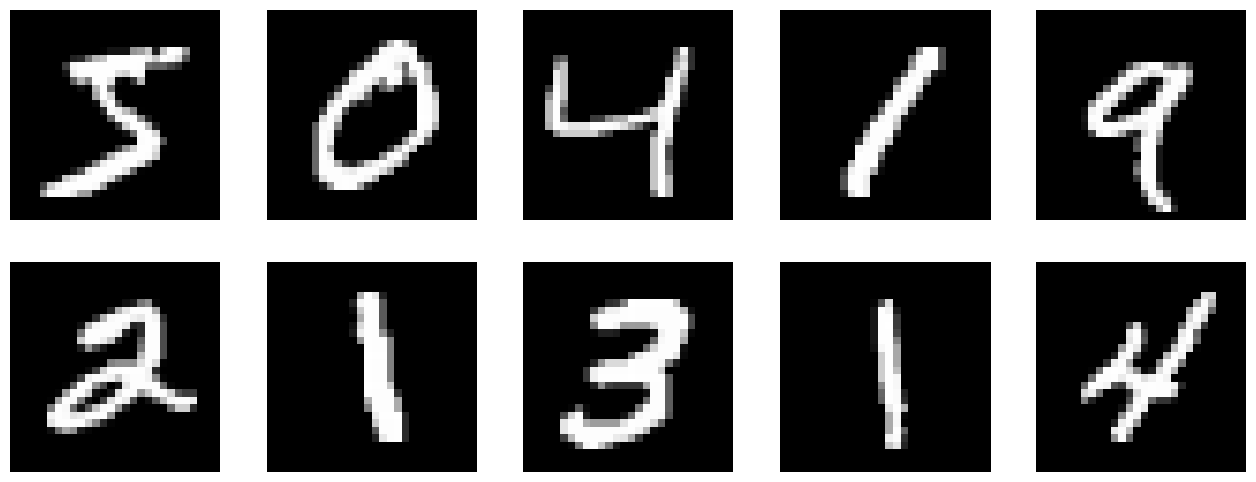

In [165]:
# show some images

plt.figure(figsize=(16, 6))
for i in range(10):
  plt.subplot(2, 5, i + 1)
  image, _ = train_loader.dataset.__getitem__(i)
  plt.imshow(image.squeeze().numpy(), cmap='Grays_r')
  plt.axis('off')

# Training and Inferance

Next, we define the functions which we will use for training and inference for handwritten digit recognition using MNIST dataset.

We begin with a function for training over a single **epoch** (a complete loop over the dataset). Note that the function takes as input, in addition to the **epoch** index and the *model* structure, we include a variable indicating how to permute the pixels (comprised of $28^2 = 784$ entries). We will use this permutation in the squel to study the sensitivity of convolutional networks to non-structural perserving permutations of images.

The optimizer we are using is SGD with momentum, and we use the negative log likelihood loss, which when combined with log-softmax outputs, boils down to cross enrtopy loss.

The statment <code>model.train()</code> tells the model that we are training it. So effectively layers like dropout, batchnorm, etc., which cehave differently on the train and test procedures, behave accordignly. For the same reason, we ust <code>model.eval()</code> in the test procedure.

In [166]:
def train(epoch, train_loader, model, device, perm=torch.arange(0, 784).long()):
  model.train()
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
  for batch_idx, (data, label) in enumerate(train_loader):
    # send to device
    data, label = data.to(device), label.to(device)

    # permute pixels
    data = data.view(-1, 28*28)
    data = data[:, perm]
    data = data.view(-1, 1, 28, 28)


    optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output, label)
    loss.backward()
    optimizer.step()

    if batch_idx % 100 == 0:
      print(f"Train Epoch: {epoch} [Accuracy: {batch_idx * len(data) / len(train_loader.dataset)} ({100. * batch_idx / len(train_loader)})% \t Loss: {loss.item()}]")

Before defining the test function, which uses the samples in the test loader, we initialize a list for saving the test accuracy on each test we carry out.

In [167]:
accuracy_list = []

def test(model, test_loader, device, perm=torch.arange(0, 784).long()):
  model.eval()
  test_loss = 0.0
  correct = 0.0
  for data, label in test_loader:
    # send to device
    data, label = data.to(device), label.to(device)

    # permute pixels
    data = data.view(-1, 28*28)
    data = data[:, perm]
    data = data.view(-1, 1, 28, 28)

    output = model(data)
    test_loss += F.nll_loss(output, label, reduction='sum').item() # sum up batch loss
    pred = output.data.max(1, keepdim=True)[1] # get the index of the maximum log-probability
    correct += pred.eq(label.data.view_as(pred)).cpu().sum().item()

  test_loss /= len(test_loader.dataset)
  accuracy = 100. * correct / len(test_loader.dataset)
  accuracy_list.append(accuracy)
  print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f})%)\n'.format(test_loss, correct, len(test_loader.dataset), accuracy))

# Compared Neural Network Models

**Model 1: fully connected:** We use three hyperparameter <code>n_layer</code> dictates the input and output size of the second hidden layer. The output is a log-softmax layer (same as softmax only with a log taken to improve stability).

The <code>tensor.view()</code> method just reshapes the tensor data to be the desired input size, while the $-1$ simply states that we don't know (or care) about the number of images forwarded when reshaping.

Note that each image is reshaped into $748 \times 1$ vector as the fully connected network treats the image as a vector of pixels.

In [168]:
class FC2Layer(nn.Module):
  def __init__(self, input_size, n_hidden, output_size):
    super(FC2Layer, self).__init__()
    self.input_size = input_size
    self.network = nn.Sequential(
        nn.Linear(input_size, n_hidden),
        nn.ReLU(),
        nn.Linear(n_hidden, n_hidden),
        nn.ReLU(),
        nn.Linear(n_hidden, output_size),
        nn.LogSoftmax(dim=1)
    )

  def forward(self, x):
    x = x.view(-1, self.input_size)
    return self.network(x)

Training the fully connected model over $3$ epoch. We also print the overall number of trainable parameters when the second layer is completed of merely $8$ hidden units.

In [169]:
n_hidden = 8 # number of hidden units
model_fnn = FC2Layer(input_size, n_hidden, output_size).to(device)
print("Number of parameters : {}".format(get_n_params(model_fnn)))

for epoch in range(0, 3):
  train(epoch, train_loader, model_fnn, device)

test(model_fnn, test_loader, device)

Number of parameters : 6442
Train Epoch: 0 [Accuracy: 0.0 (0.0)% 	 Loss: 2.2856616973876953]
Train Epoch: 0 [Accuracy: 0.10666666666666667 (10.660980810234541)% 	 Loss: 1.9400410652160645]
Train Epoch: 0 [Accuracy: 0.21333333333333335 (21.321961620469082)% 	 Loss: 1.3715078830718994]
Train Epoch: 0 [Accuracy: 0.32 (31.982942430703623)% 	 Loss: 1.0953508615493774]
Train Epoch: 0 [Accuracy: 0.4266666666666667 (42.643923240938165)% 	 Loss: 0.526841402053833]
Train Epoch: 0 [Accuracy: 0.5333333333333333 (53.304904051172706)% 	 Loss: 0.6192013621330261]
Train Epoch: 0 [Accuracy: 0.64 (63.96588486140725)% 	 Loss: 0.8095743656158447]
Train Epoch: 0 [Accuracy: 0.7466666666666667 (74.6268656716418)% 	 Loss: 0.6374092698097229]
Train Epoch: 0 [Accuracy: 0.8533333333333334 (85.28784648187633)% 	 Loss: 0.44285595417022705]
Train Epoch: 0 [Accuracy: 0.96 (95.94882729211088)% 	 Loss: 0.4439142644405365]
Train Epoch: 1 [Accuracy: 0.0 (0.0)% 	 Loss: 0.4987056255340576]
Train Epoch: 1 [Accuracy: 0.1066

**Model 2: Convolutional neural network:** The convolutional neural network is comprised of two convolutional layers with kernel size $F_c = 5$. The number of input channels is $D1 = 1$ (grayscale image), and the number of output channels $D_2$ is a hyperparameter <code>n_features</code> contolling the number of trainable parameters. Each convolutional layer is followed by a ReLU activation function and a MaxPooling layer with kernel size of $F_p  2$.

Note that after passing through the first convolutional layes, the $H_1 \times W_1 = 28 \times 28$ image is converted into <code>n_features</code> images of size $H_2(=H_1-F_c+1) \times W_2(=W_1 - F_c +1) = 24 \times 24$, which after MaxPooling is reduced to size $12 \times 12$.

Then, the second layer converts each channel into size $H_3(=H_2 - F_c +1) \times W_3(=W_2 - F_c +1) = 8 \times 8$, which after MaxPooling is reduced to $4 \times 4$.

For this reason, the input to the fully connected layer is of size <code>n_features</code> = $4\cdot 4$.

In [170]:
class CNN(nn.Module):
  def __init__(self, input_size, n_features, output_size):
    super(CNN, self).__init__()
    self.n_features = n_features
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_features, kernel_size=5)
    self.conv2 = nn.Conv2d(n_features, n_features, kernel_size=5)
    self.fc1 = nn.Linear(n_features * 4 * 4, 50)
    self.fc2 = nn.Linear(50, output_size)

  def forward(self, x, verbose=False):
    x = self.conv1(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2)
    x = x.view(-1, self.n_features*4*4)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    x = F.log_softmax(x, dim=1)
    return x

Training the fully connected model over $3$ epoch. We also print the overall number of trainable parameters when the number of channels is $D_2 = 6$.

In [171]:
# Training settings
n_feature = 6 # number of feature maps
model_cnn = CNN(input_size, n_feature, output_size).to(device)
print("Number of parameters : {}".format(get_n_params(model_cnn)))

for epoch in range(0, 3):
  train(epoch, train_loader, model_cnn, device)

test(model_cnn, test_loader, device)

Number of parameters : 6422
Train Epoch: 0 [Accuracy: 0.0 (0.0)% 	 Loss: 2.313737630844116]
Train Epoch: 0 [Accuracy: 0.10666666666666667 (10.660980810234541)% 	 Loss: 2.265366315841675]
Train Epoch: 0 [Accuracy: 0.21333333333333335 (21.321961620469082)% 	 Loss: 1.7967400550842285]
Train Epoch: 0 [Accuracy: 0.32 (31.982942430703623)% 	 Loss: 0.9321084022521973]
Train Epoch: 0 [Accuracy: 0.4266666666666667 (42.643923240938165)% 	 Loss: 0.458054780960083]
Train Epoch: 0 [Accuracy: 0.5333333333333333 (53.304904051172706)% 	 Loss: 0.2506787180900574]
Train Epoch: 0 [Accuracy: 0.64 (63.96588486140725)% 	 Loss: 0.19511523842811584]
Train Epoch: 0 [Accuracy: 0.7466666666666667 (74.6268656716418)% 	 Loss: 0.31098100543022156]
Train Epoch: 0 [Accuracy: 0.8533333333333334 (85.28784648187633)% 	 Loss: 0.45523393154144287]
Train Epoch: 0 [Accuracy: 0.96 (95.94882729211088)% 	 Loss: 0.24835632741451263]
Train Epoch: 1 [Accuracy: 0.0 (0.0)% 	 Loss: 0.2866092026233673]
Train Epoch: 1 [Accuracy: 0.106

# Permuting the images

We have noted that the convolutional network operates much better than a fully connected one with the same number of trainable parameters, due to its ability to exploit the spatial structures in the image.

Now, let's drop the structure of the images. We de this by applaying a random permutation of the pixels. This is what a permuted image looks like:

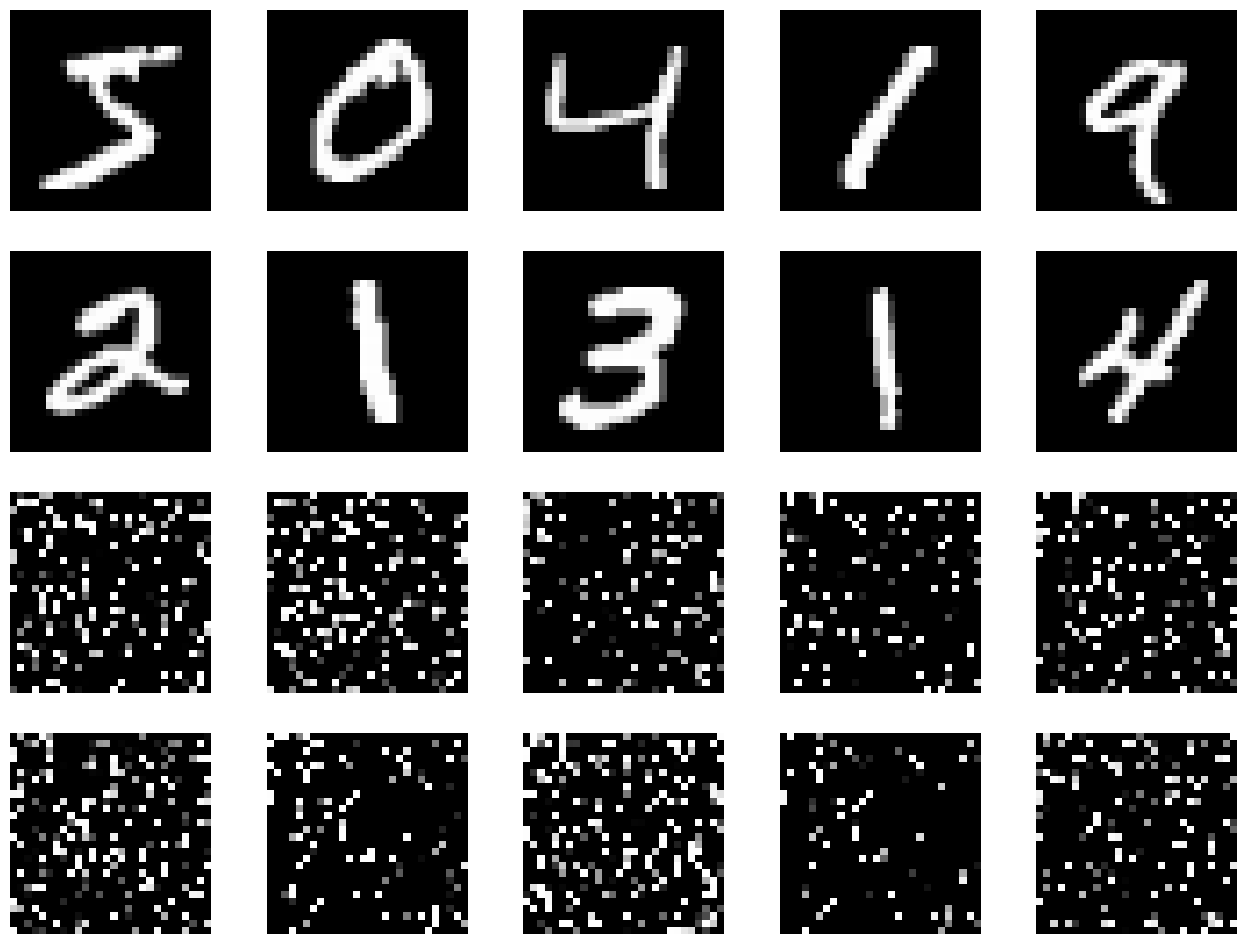

In [172]:
perm = torch.randperm(784)
plt.figure(figsize=(16, 12))
for i in range(10):
  image, _ = train_loader.dataset.__getitem__(i)
  # permute pixel
  image_perm = image.view(-1, 28*28).clone()
  image_perm = image_perm[:, perm]
  image_perm = image_perm.view(-1, 1, 28, 28)
  plt.subplot(4, 5, i + 1)
  plt.imshow(image.squeeze().numpy(), cmap='Grays_r')
  plt.axis('off')
  plt.subplot(4, 5, i + 11)
  plt.imshow(image_perm.squeeze().numpy(), cmap='Grays_r')
  plt.axis('off')

Now let's train the convolutional network using the same dataset only with permuted pixels.

In [173]:
model_cnn = CNN(input_size, n_feature, output_size).to(device)

for epoch in range(0, 3):
  train(epoch, train_loader, model_cnn, device, perm)


test(model_cnn, test_loader, device, perm)

Train Epoch: 0 [Accuracy: 0.0 (0.0)% 	 Loss: 2.295799493789673]
Train Epoch: 0 [Accuracy: 0.10666666666666667 (10.660980810234541)% 	 Loss: 2.301278829574585]
Train Epoch: 0 [Accuracy: 0.21333333333333335 (21.321961620469082)% 	 Loss: 2.278970718383789]
Train Epoch: 0 [Accuracy: 0.32 (31.982942430703623)% 	 Loss: 2.24017071723938]
Train Epoch: 0 [Accuracy: 0.4266666666666667 (42.643923240938165)% 	 Loss: 2.151542901992798]
Train Epoch: 0 [Accuracy: 0.5333333333333333 (53.304904051172706)% 	 Loss: 1.8921681642532349]
Train Epoch: 0 [Accuracy: 0.64 (63.96588486140725)% 	 Loss: 1.8188202381134033]
Train Epoch: 0 [Accuracy: 0.7466666666666667 (74.6268656716418)% 	 Loss: 1.388582468032837]
Train Epoch: 0 [Accuracy: 0.8533333333333334 (85.28784648187633)% 	 Loss: 1.1316070556640625]
Train Epoch: 0 [Accuracy: 0.96 (95.94882729211088)% 	 Loss: 0.9408385753631592]
Train Epoch: 1 [Accuracy: 0.0 (0.0)% 	 Loss: 0.8168494701385498]
Train Epoch: 1 [Accuracy: 0.10666666666666667 (10.660980810234541)%

... and the fully connected network ...

In [174]:
model_fnn = FC2Layer(input_size, n_hidden, output_size).to(device)

for epoch in range(0, 3):
  train(epoch, train_loader, model_fnn, device, perm)

test(model_fnn, test_loader, device, perm)

Train Epoch: 0 [Accuracy: 0.0 (0.0)% 	 Loss: 2.355746269226074]
Train Epoch: 0 [Accuracy: 0.10666666666666667 (10.660980810234541)% 	 Loss: 2.253342866897583]
Train Epoch: 0 [Accuracy: 0.21333333333333335 (21.321961620469082)% 	 Loss: 1.7692818641662598]
Train Epoch: 0 [Accuracy: 0.32 (31.982942430703623)% 	 Loss: 1.3317378759384155]
Train Epoch: 0 [Accuracy: 0.4266666666666667 (42.643923240938165)% 	 Loss: 1.2256178855895996]
Train Epoch: 0 [Accuracy: 0.5333333333333333 (53.304904051172706)% 	 Loss: 0.7291741371154785]
Train Epoch: 0 [Accuracy: 0.64 (63.96588486140725)% 	 Loss: 0.593571662902832]
Train Epoch: 0 [Accuracy: 0.7466666666666667 (74.6268656716418)% 	 Loss: 0.7041894197463989]
Train Epoch: 0 [Accuracy: 0.8533333333333334 (85.28784648187633)% 	 Loss: 0.8114084601402283]
Train Epoch: 0 [Accuracy: 0.96 (95.94882729211088)% 	 Loss: 0.6907952427864075]
Train Epoch: 1 [Accuracy: 0.0 (0.0)% 	 Loss: 0.3983154296875]
Train Epoch: 1 [Accuracy: 0.10666666666666667 (10.660980810234541)

What do we see when we comparing the convolutional network and the fully connected one?

In [175]:
print(len(accuracy_list))

4


Text(0.5, 1.0, 'Performance comparison')

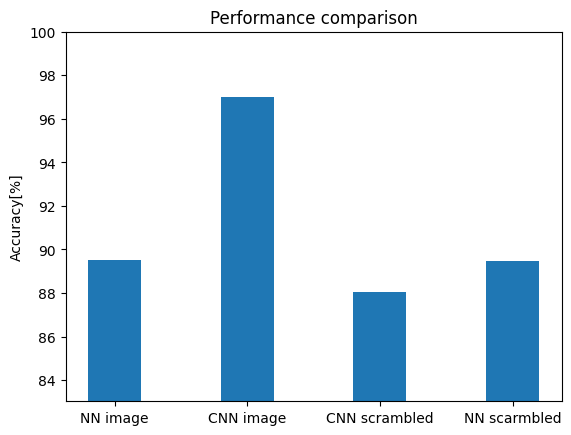

In [176]:
plt.bar(('NN image', 'CNN image', 'CNN scrambled', 'NN scarmbled'), accuracy_list, width=0.4)
plt.ylim((min(accuracy_list)-5, 100))
# plt.xlabel('Model')
plt.ylabel('Accuracy[%]')
plt.title('Performance comparison')